# Imports

In [34]:
from torch.utils.data import DataLoader, random_split
import torch
from data import ParenthesizationDataset, ParenthesizationModel
from train import train_one_epoch, evaluate_model, analyze_confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib as mpl
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np

# Initialization
Set the parameters here for training and initialize the train/test datasets, data loaders, model, loss function and optimizer.

In [35]:
n = 7
num_epochs = 50
train_split, test_split = 0.8, 0.2
learning_rate = 0.001
momentum = 0.9
batch_size = 32

dataset = ParenthesizationDataset(n)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Model, Loss, and Optimizer
model = ParenthesizationModel(n)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Debug: Ensure DataLoader is working correctly
print(f"Number of training batches: {len(train_loader)}")

confusion_matrix = evaluate_model(model, test_loader)
print("Confusion Matrix:")
print(confusion_matrix)


Number of training batches: 27
Confusion Matrix:
[[256, 173], [283, 146]]


# Training the model
* Call `train_one_epoch` repeatedly to train the model once over the entire training dataset.
* Print out the epoch number and loss after each training call to verify that the loss is going down.
* Record the loss values in a list so that it can be plotted in the cell below.
* After training, call `evaluate_model` to get the confusion matrix.
* Save the model as `models/linear_model_{n}.pt`.

In [36]:
# Training loop
if not os.path.exists('models'):
    os.makedirs('models')


train_losses = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)  # Collect the loss values
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss}")

# Evaluation
confusion_matrix = evaluate_model(model, test_loader)
print("Confusion Matrix:")
print(confusion_matrix)

torch.save(model.state_dict(), f'models/linear_model_{n}.pt')

Epoch 1/50, Loss: 18.95295000076294
Epoch 2/50, Loss: 17.87204110622406
Epoch 3/50, Loss: 16.97793036699295
Epoch 4/50, Loss: 16.21744668483734
Epoch 5/50, Loss: 15.492719799280167
Epoch 6/50, Loss: 14.881952464580536
Epoch 7/50, Loss: 14.32257854938507
Epoch 8/50, Loss: 13.828549474477768
Epoch 9/50, Loss: 13.378339767456055
Epoch 10/50, Loss: 12.961536198854446
Epoch 11/50, Loss: 12.612570226192474
Epoch 12/50, Loss: 12.290787309408188
Epoch 13/50, Loss: 11.987516790628433
Epoch 14/50, Loss: 11.696389198303223
Epoch 15/50, Loss: 11.446857273578644
Epoch 16/50, Loss: 11.240372657775879
Epoch 17/50, Loss: 10.984900414943695
Epoch 18/50, Loss: 10.786443322896957
Epoch 19/50, Loss: 10.607972294092178
Epoch 20/50, Loss: 10.41385766863823
Epoch 21/50, Loss: 10.256912648677826
Epoch 22/50, Loss: 10.135441541671753
Epoch 23/50, Loss: 9.950945317745209
Epoch 24/50, Loss: 9.811700701713562
Epoch 25/50, Loss: 9.707089811563492
Epoch 26/50, Loss: 9.600254535675049
Epoch 27/50, Loss: 9.4719601869

# Plot the loss curve
Plot the loss curve with appropriate figure title and axis labels. Save the resulting figure in `figures/loss_curve_{n}.png`.

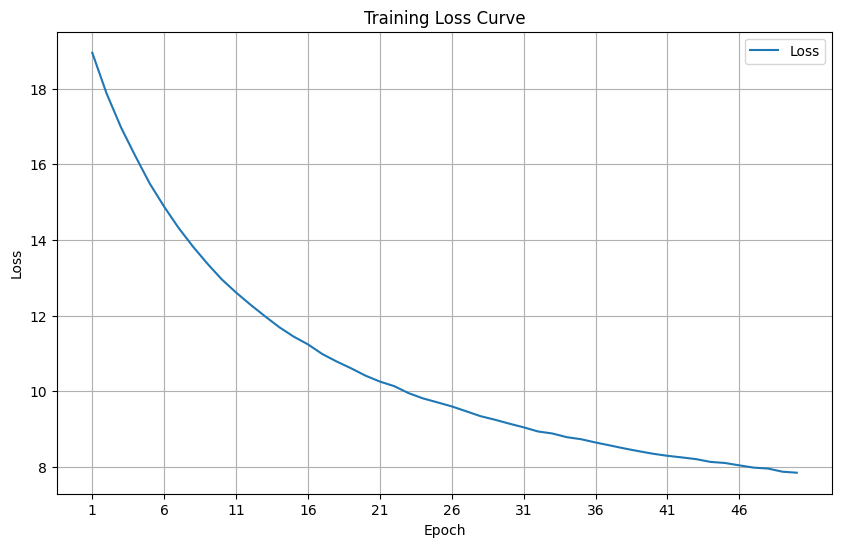

In [37]:

def plot_loss_curve(losses, n, num_epochs):
    plt.figure(figsize=(10, 6))
    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, losses, label='Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, num_epochs + 1, step_size))  # Set the x-axis to show every epoch
    plt.legend()
    plt.grid(True)
    # Save the figure
    plt.savefig(f'figures/loss_curve_{n}.png')
    plt.show()

# Ensure the 'figures' directory exists
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

# Example usage
num_epochs = 50  # Make sure this matches your actual number of epochs
step_size = 5  # Set the desired step size for the x-axis ticks
n = 1  # Example identifier
plot_loss_curve(train_losses, n, num_epochs)






# Analyze accuracy using the confusion matrix
- Print out the accuracy within each of the prediction classes.
- Print out the size of each prediction class.
- Print out the overall accuracy.

In [38]:
class_accuracy, class_size, overall_accuracy = analyze_confusion_matrix(confusion_matrix)

# Print results
for i, (accuracy, size) in enumerate(zip(class_accuracy, class_size)):
    print(f"Class {i} - Accuracy: {accuracy:.2f}, Size: {size}")

print(f"Overall Accuracy: {overall_accuracy:.2f}")

Class 0 - Accuracy: 0.83, Size: 429
Class 1 - Accuracy: 1.00, Size: 429
Overall Accuracy: 0.91


# Plot the model weights
Can you interpret what the model is doing? Plot the model weights using `plt.imshow()` to get a heatmap. Choose a colormap from https://matplotlib.org/stable/users/explain/colors/colormaps.html that you prefer. I default to the `bwr` colormap where negative values are blue, positive value are red, and values close to zero are white.

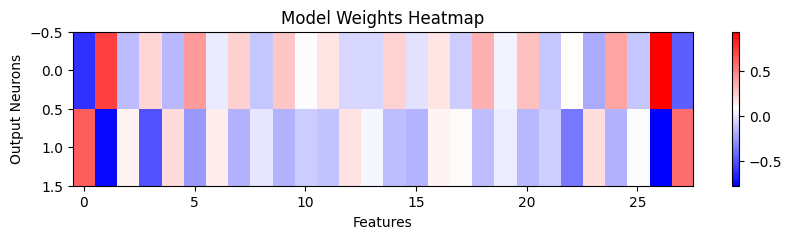

In [51]:
"""The heat map represents the weights of the model. The alternating colors
   show that the model is learning the repetive pattern of the parentheses.
   The edges of the heat map show us that the model finds the early and last inputs
   to be the most important while the middle has less impact on the decision making
"""
def plot_model_weights(model, colormap='bwr'):
    weights = model.fc.weight.data.numpy()
    plt.figure(figsize=(10, 2))
    plt.imshow(weights, aspect='auto', cmap=colormap)
    plt.colorbar()
    plt.title('Model Weights Heatmap')
    plt.xlabel('Features')
    plt.ylabel('Output Neurons')
    plt.show()

plot_model_weights(model, colormap='bwr')

# "Translate" the model into code.
Implement `simple_evaluate` which condenses the model's "logic" into a single if-else statement. Run this evaluation function over the test set to produce a new confusion matrix and see how it performs compared to the model you train.

In [50]:
def simple_evaluate(inputs, weights, bias):
    """
    Condense the linear model's logic into a single if-else statement with weights and bias.

    Args:
    - inputs (torch.Tensor): The input features.
    - weights (np.array): The weights from the trained model.
    - bias (np.array): The bias from the trained model.

    Returns:
    - int: The predicted label (0 or 1).
    """
    weighted_sum = np.dot(inputs.numpy(), weights.T) + bias
    weighted_sum_scalar = weighted_sum[0]  # Ensure weighted_sum is a scalar
    if weighted_sum_scalar > 0:
        return 1
    else:
        return 0

# Function to evaluate the simple rule on the test set
def evaluate_simple_rule(test_loader, weights, bias):
    """
    Evaluate the simplified rule on the test set.

    Args:
    - test_loader (DataLoader): The test data loader.
    - weights (np.array): The weights from the trained model.
    - bias (np.array): The bias from the trained model.

    Returns:
    - list: The confusion matrix.
    """
    simple_confusion_matrix = [[0, 0], [0, 0]]
    for inputs, targets in test_loader:
        inputs = inputs.numpy()
        predictions = [simple_evaluate(torch.tensor(x), weights, bias) for x in inputs]
        for i in range(len(targets)):
            actual = int(targets[i].item())
            predicted = int(predictions[i])
            simple_confusion_matrix[actual][predicted] += 1
    return simple_confusion_matrix

# Simple evaluation
weights = model.fc.weight.data.numpy()
bias = model.fc.bias.data.numpy()
simple_confusion_matrix = evaluate_simple_rule(test_loader, weights, bias)
print("Simple Evaluation Confusion Matrix:")
print(simple_confusion_matrix)


Simple Evaluation Confusion Matrix:
[[79, 350], [424, 5]]
